In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
from keras.models import load_model
import segmentation_models as sm

seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

BATCH_SIZE = 4

ROOT = "./../Data/Hannover/"
TEST_DIR = "_Test512/"

Segmentation Models: using `keras` framework.


In [2]:
from PIL import Image

test_images = np.array([np.array(Image.open(fname)) for fname in glob.glob(ROOT + TEST_DIR + 'Images/samples/*')])
test_masks = np.array([np.array(Image.open(fname).convert('L')) for fname in glob.glob(ROOT + TEST_DIR + 'Masks/samples/*')]) # convert to lose two channels


In [3]:
import get_data_generators

augmentation = {
}

test_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), test_images_path=ROOT + TEST_DIR + "Images", test_targets_path=ROOT + TEST_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)
test_gen = test_gen[0]

Found 980 images belonging to 1 classes.
Found 980 images belonging to 1 classes.


In [4]:
model_path = "./../Models/Binary/512/bike_mapper_scratch_double-dropout_Train3607_Val313_Test980_No-Aug_IoU2986_f4490.h5"
modelEval = load_model(model_path, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore()})

In [5]:
modelEval.evaluate(test_gen.data, steps=test_gen.samplesPerBatch)

245/245 [==============================] - 15s 49ms/step - loss: 0.5510 - iou_score: 0.2986 - f1-score: 0.4490


[0.5510475635528564, 0.298628568649292, 0.44895240664482117]

In [5]:
predictions = modelEval.predict(test_gen.data, steps=test_gen.samplesPerBatch)

245/245 [==============================] - 15s 49ms/step


In [ ]:
import inference

pred = inference.predict(modelEval, './tiff/_Test/Images/samples/1_10078675_15.tiff')
print(pred)

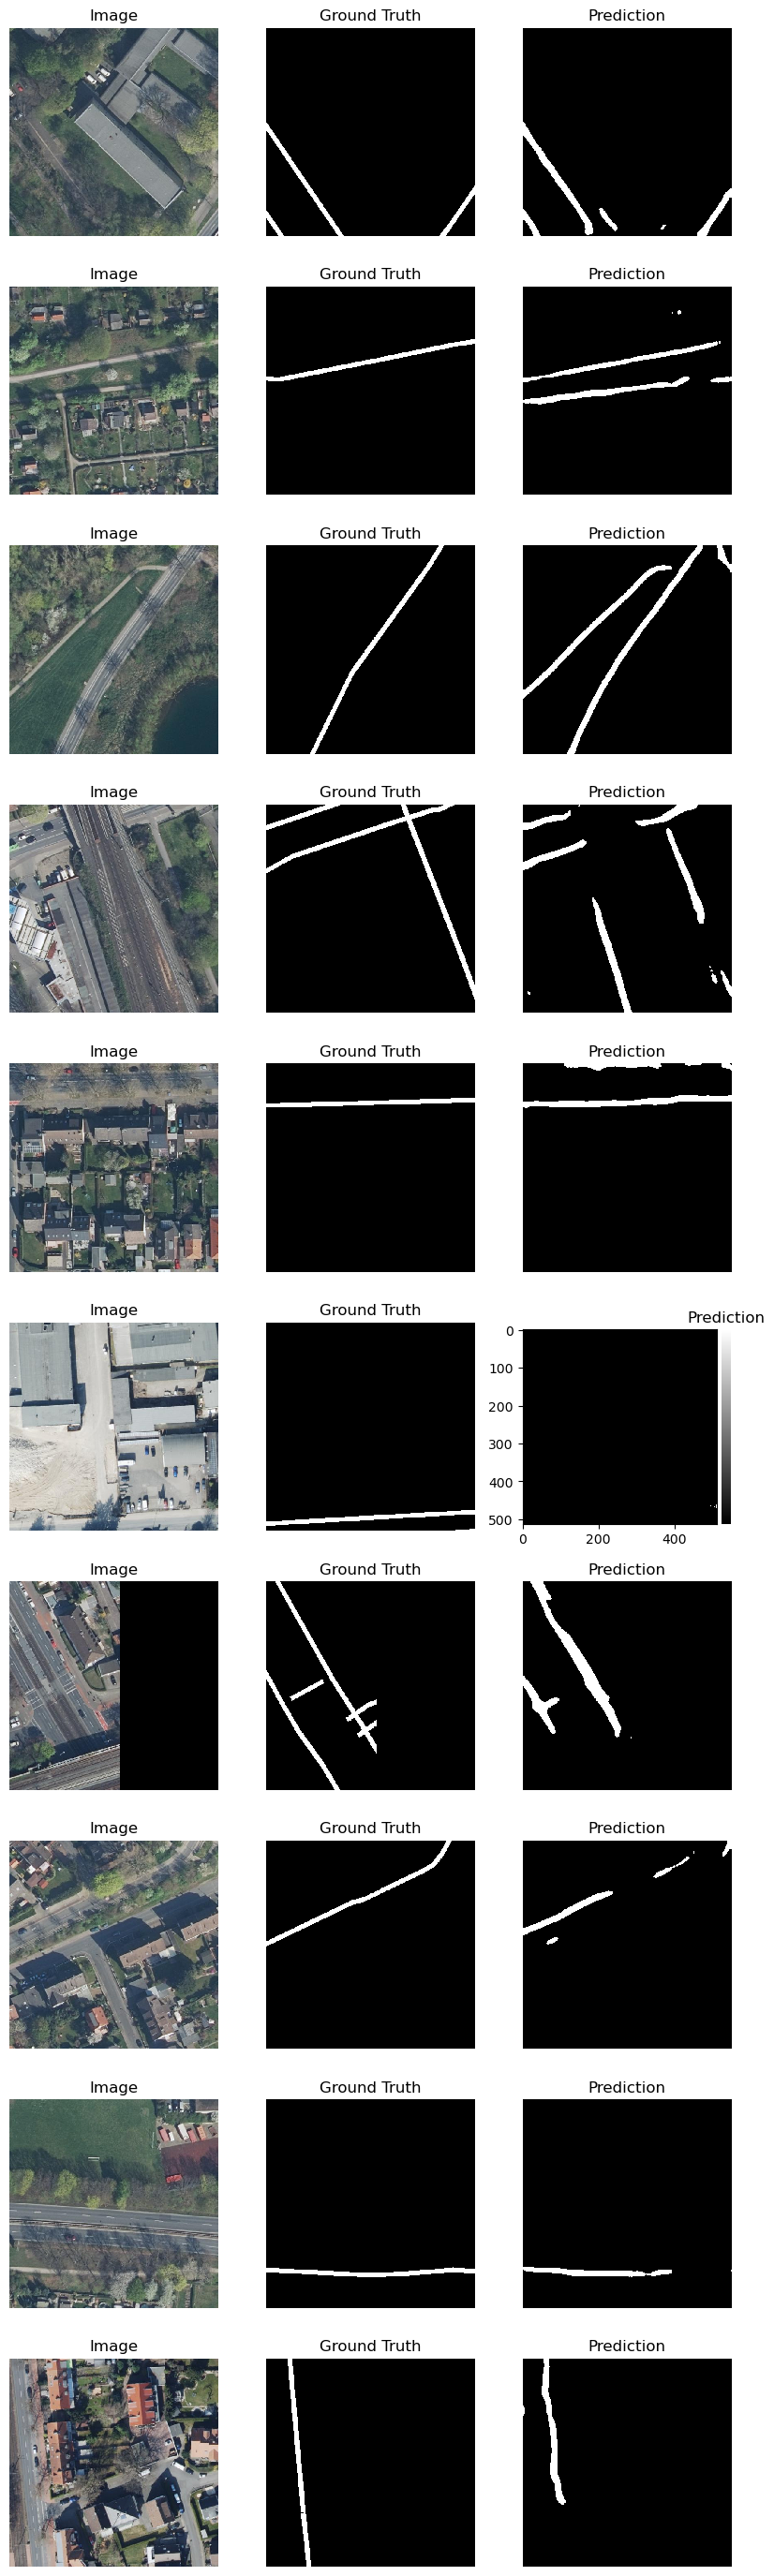

In [9]:
thresh_val = 0.1

ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (8, 28))
for i in range(1, num_samples*3, 3):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 3, i)
  imshow(test_images[ix][:,:,:])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  show = np.squeeze(test_masks[ix][:,:])
  imshow(show)
  plt.title("Ground Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  show = np.squeeze(predictions[ix][:,:,0])
  show[show < thresh_val] = 0
  show[show >= thresh_val] = 255
  show = show.astype(np.uint8)
  imshow(show, cmap="gray")
  plt.title("Prediction")
  plt.axis('off')

plt.show()